# <center> Quantum GANs </center>

Here, we're trying to use Quantum GANs to generate hand-written images of the number 0, using a recently proposed quantum method of patches.

## A quick intro to GANs

So GANs, as you might have guessed, have something to do with images, they try and generate data that is close to the original training data. A GAN has two components, a generator and a discriminator, both of which are neural networks (in this case, fully connected). Basically, the generator generates fake images, trying to model them after the training dataset. The discriminator, on the other hand, discriminates between the fake images that the generator makes and the real images from the training dataset. Both neural networks therefore improve over the training process, and compete with other as well, trying to outsmart the other.

The loss function for GANs is $$ \min_G \max_D V(D,G) = \mathbb{E}_{x \sim p_{data}}[ \log D(x)] + \mathbb{E}_{z \sim p_z}[ \log(1 - D(G(z))] $$

Where : 
-  $x$ is the real training data sample
-  $z$ is a latent vector that the generator uses to generate fake data
-  $G(z)$ is fake data
-  $D(x)$ is the probability of the discriminator classifying real images as real
-  $D(G(z))$ is the probability of the discriminator classifying fake data as real

However, we actually define two separae loss functions to train the two networks

$$ L_D = -[y\cdot \log(D(x)) +(1-y) \cdot \log(1 - D(G(z))) ]$$

$$ L_G = -[(1-y)\cdot \log(D(G(z)))]$$

where $y$ is a binary label for real (y = 1) or fake (y = 0) data.


Here, we re-create one of the quantum GAN methods presented by Huang et al.[2]: the patch method. In this implementation, there are 4 such patches of the image, each produced by a different sub-generator. The final image is a concatenation of all the 4 patches. 

The image below is taken from https://pennylane.ai/qml/demos/tutorial_quantum_gans.html, the main source for this notebook and from where I've taken a lot of code and text.

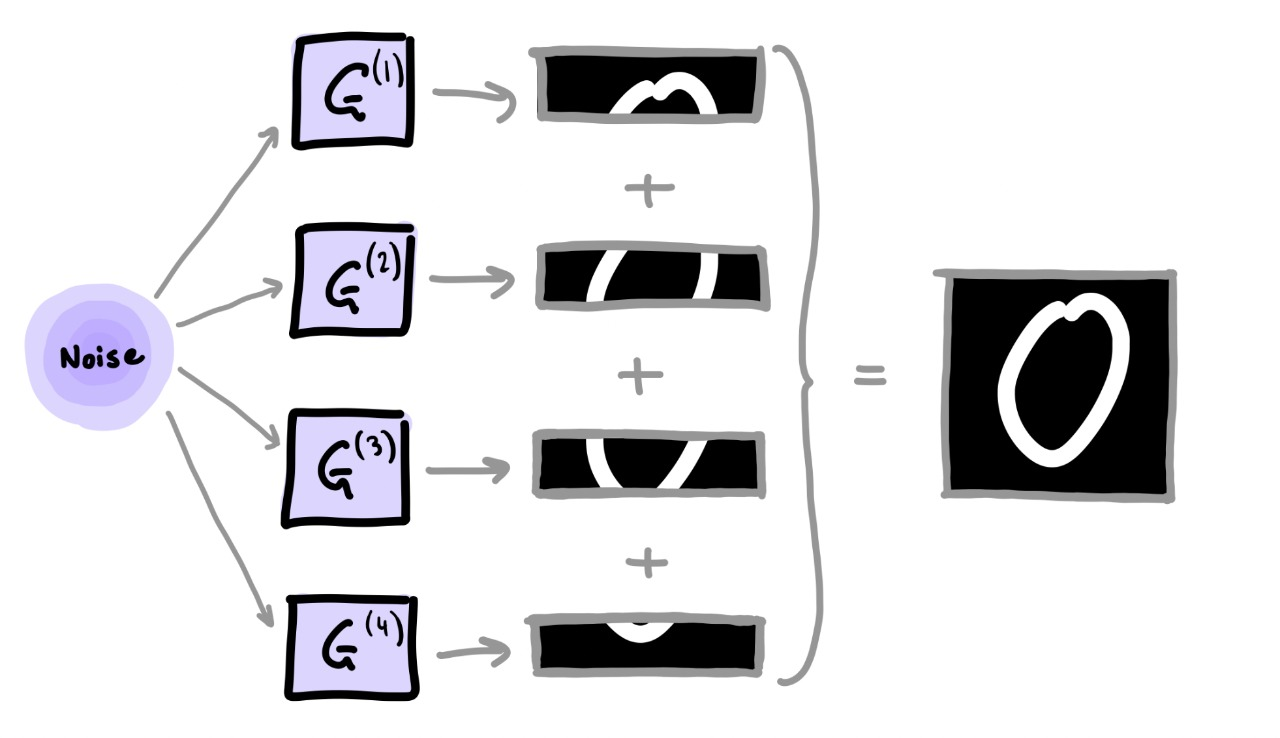

The main advantage of this method is that it is efficient when the number of qubits avalilable (computing power plays a role) is limited.

## Imports

In [2]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

In [1]:
# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Data

Here, we use a small dataset of hand-written zeros. We load them here.

In [4]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

Here, we create a data-loader instance, feeding in the dataset to the loader.

In [5]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="quantum_gans/optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

## Visualization



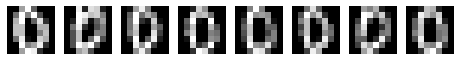

In [6]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

## Discriminator

Here, we use a fully connected neural network woith two hidden layers, with a single output representing the probability of a training image being classified as real or not.

In [7]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## Implementing the generator

Each generator $G^{i}$ has the below architecture. The overall generator consists of $N_G$ generators, each consisting of $N$ qubits.

The process from the latent vector to the output image can be split into 4 processes as shown below.

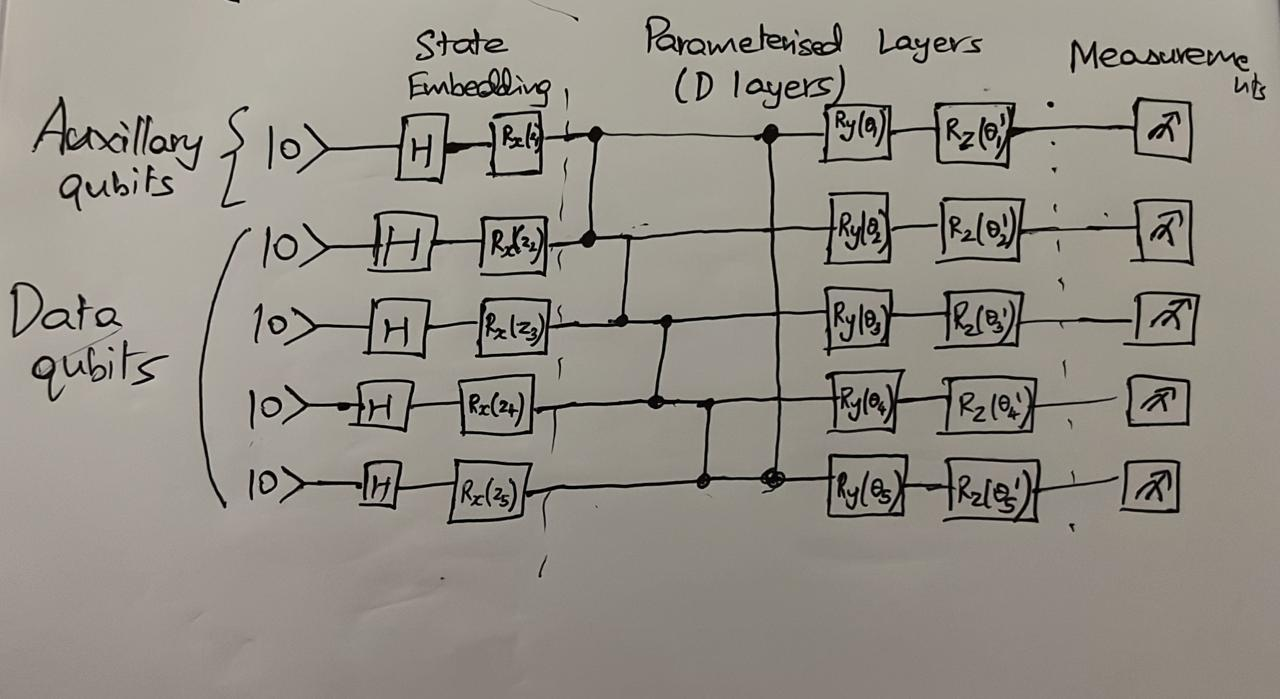

 - State Embedding : Here, a latent vector $\mathbb{R}^N$ is sampled from a uniform distribution from $\left[0,\frac{\pi}{2}\right)$. The vector is then embedded using $R_x$ gates.
 
 - Parameterized Layers : I starts with a series of control $Z$ gates, linking all the qubits together in some form. I then apply an $R_Y$ and $R_Z$ gate to each qubit, every gate consisting of a different parameter, which is meant to be learnt and optimised. The entire layer is repeated $D$ times.
 
 - Non-Linear Transform : We see that all the unitary gates acting on qubits, are all linear in nature (since they are unitary). We need some 'noise' to introduce some non-linearity, since linearity can only be sufficient in simple tasks. 

So the state before the measurement is given by $$|\Psi(z) \rangle = U_G(\theta)|z\rangle$$ where $U_G(\theta)$ represents 

In [43]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

In [44]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [45]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits, 2)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RX(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])
        qml.CZ(wires=[n_qubits - 1, 0])
        
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y][0], wires=y)
            qml.RZ(weights[i][y][1], wires=y)

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [46]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits * 2), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

In [47]:
lrG = 0.25 # Learning rate for the generator
lrD = 0.01 # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [51]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)


# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD, momentum = 0)
optG = optim.SGD(generator.parameters(), lr=lrG, momentum = 0)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.353, Generator Loss: 0.749
Iteration: 20, Discriminator Loss: 1.314, Generator Loss: 0.756
Iteration: 30, Discriminator Loss: 1.285, Generator Loss: 0.758
Iteration: 40, Discriminator Loss: 1.246, Generator Loss: 0.753
Iteration: 50, Discriminator Loss: 1.215, Generator Loss: 0.763
Iteration: 60, Discriminator Loss: 1.182, Generator Loss: 0.770
Iteration: 70, Discriminator Loss: 1.097, Generator Loss: 0.794
Iteration: 80, Discriminator Loss: 1.083, Generator Loss: 0.790
Iteration: 90, Discriminator Loss: 1.024, Generator Loss: 0.818
Iteration: 100, Discriminator Loss: 1.003, Generator Loss: 0.822
Iteration: 110, Discriminator Loss: 0.942, Generator Loss: 0.812
Iteration: 120, Discriminator Loss: 0.844, Generator Loss: 0.835
Iteration: 130, Discriminator Loss: 0.894, Generator Loss: 0.796
Iteration: 140, Discriminator Loss: 1.015, Generator Loss: 0.705
Iteration: 150, Discriminator Loss: 1.145, Generator Loss: 0.633
Iteration: 160, Discriminator Loss

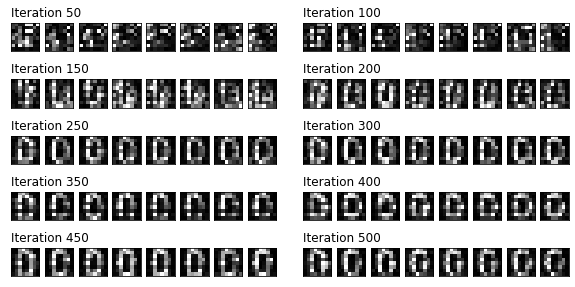

In [52]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

First change : Changing the number of ancillary qubits from 1 to 2 : I didn't really see any noticeable difference, the accuracies were almost the same as before, I did have to change the learning rates slightly to prevent it from oscillating too much. Even the images I got were almost the same as before. (I guess I've also tinkered with the learning rates here, I've done it a lot for my actual paper as well.

I also tried increasing the depth of the parameterized quantum circuit to 10, it took me a long time to run (don't try it) and actually gave worse values than the original (of course, I hadn't changed any of the other parameters such as learning rate, number of qubits, etc.

Since we're using SGD, I flirted with the idea of using Adam instead, however, the values fluctuated too much even when I did my best to control it using the learning rate. That wasn't successful. Instead, I tried to introduce another parameter in SGD, that of momentum. Momentum can be visualised in a manenr similar to the physical version of it, that is, it takes into account what the value was before the update while updating it, thereby letting it keep some of its 'momentum', so to speak. I tried some small momentum values, like 0.2 for the discriminator and 0.05 for the generator, they just made it more unstable.